# Case 3. Medical text categorization
Sanni Tolonen<br>
18.3.2018<br>
Cognitive Systems for Health Technology Applications, Spring 2018<br>
Helsinki Metropolia University of Applied Sciences

## 1. Objectives
The aim of this assignment is to learn to use recurrent and 1D convolutional neural networks to
categorize medical texts.

## 2. Required libraries

In [8]:
import os
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

## 3. Data description and preprocessing

The data used in this case is the Cardiovascular diseases abstract database from MEDLINE. It includes medical abstracts from the MeSH categories of the year 1991. The first 20,000 documents are already divided for training and testing sets, 10 000 for training and 10 000 for testing. The data is downloaded from http://disi.unitn.it/moschitti/corpora.htm. 

The labels in this dataset are:
<ul>
<li>Bacterial Infections and Mycoses                      C01</li>
<li>Virus Diseases                                        C02</li>
<li>Parasitic Diseases                                    C03</li>
<li>Neoplasms                                             C04</li>
<li>Musculoskeletal Diseases                              C05</li>
<li>Digestive System Diseases                             C06</li>
<li>Stomatognathic Diseases                               C07</li>
<li>Respiratory Tract Diseases                            C08</li>
<li>Otorhinolaryngologic Diseases                         C09</li>
<li>Nervous System Diseases                               C10</li>
<li>Eye Diseases                                          C11</li>
<li>Urologic and Male Genital Diseases                    C12</li>
<li>Female Genital Diseases and Pregnancy Complications   C13</li>
<li>Cardiovascular Diseases                               C14</li>
<li>Hemic and Lymphatic Diseases                          C15</li>
<li>Neonatal Diseases and Abnormalities                   C16</li>
<li>Skin and Connective Tissue Diseases                   C17</li>
<li>Nutritional and Metabolic Diseases                    C18</li>
<li>Endocrine Diseases                                    C19</li>
<li>Immunologic Diseases                                  C20</li>
<li>Disorders of Environmental Origin                     C21</li>
<li>Animal Diseases                                       C22</li>
<li>Pathological Conditions, Signs and Symptoms           C23</li>
</ul>

### Processing raw data

Here the medical abstracts and labels are downloaded. The abstracts are collected into a list of strings and labels are collected to a list of labels. 

In [3]:
ohsumed_dir = 'ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)

### Tokenize the text of the raw data
The data is tokenized and maximum length of text and number of words is defined. 

In [4]:
maxlen = 250
max_words = 20000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


### Shape the data and labels
Here ther data is shaped into the right shape.

In [5]:
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 250)
Shape of labels tensor: (10433, 23)


### Shuffle the data and labels
And finally here the data is shuffled. Shuffeling is important. Otherwise when splitting the data into training and validation sets the  validation set will consist only of abstracts from last two categories.

In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

## 4. Modeling and compilation

This is a recurrent neural network. It is build by using Keras Sequential model. At first there is an Embedding layer. It's purpose is to turn positive integers into dense vectors. After that there is two LSTM recurrent layers. Dropout and recurrent_dropout arguments are used here to avoid overfitting. Finally there is one Dense layer with softmax activation to split data to the label 23 categories.

In [9]:
model = Sequential()
model.add(Embedding(max_words, 109, input_length=maxlen))
model.add(LSTM(100, return_sequences = True, dropout = 0.4, recurrent_dropout = 0.2))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.4))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 109)          2180000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 100)          84000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 23)                2323      
Total params: 2,346,723
Trainable params: 2,346,723
Non-trainable params: 0
_________________________________________________________________


## 5. Training and validation

Training is executed with .fit() method. 30% from the training set is split for validation is with validation_split argument.

In [10]:
t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 30,
                   batch_size = 32,
                   validation_split = 0.3)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 7303 samples, validate on 3130 samples
Epoch 1/30
7303/7303 [==============================] - 202s 28ms/step - loss: 2.8213 - acc: 0.1714 - val_loss: 2.7533 - val_acc: 0.1987
Epoch 2/30
7303/7303 [==============================] - 204s 28ms/step - loss: 2.6846 - acc: 0.1921 - val_loss: 2.6619 - val_acc: 0.2080
Epoch 3/30
7303/7303 [==============================] - 202s 28ms/step - loss: 2.5906 - acc: 0.2151 - val_loss: 2.6646 - val_acc: 0.2010
Epoch 4/30
7303/7303 [==============================] - 201s 27ms/step - loss: 2.5042 - acc: 0.2404 - val_loss: 2.6384 - val_acc: 0.2419
Epoch 5/30
7303/7303 [==============================] - 190s 26ms/step - loss: 2.3954 - acc: 0.2770 - val_loss: 2.6049 - val_acc: 0.2470
Epoch 6/30
7303/7303 [==============================] - 190s 26ms/step - loss: 2.2856 - acc: 0.3044 - val_loss: 2.6279 - val_acc: 0.2425
Epoch 7/30
7303/7303 [==============================] - 200s 27ms/step - loss: 2.1874 - acc: 0.3340 - val_loss: 2.6645 - val_acc: 

## 6. Evaluation

Here the model is tested with  the testing set. Model.evaluate function computes testing sets loss function and accuracy.

In [11]:
# download and preprocess the test data

test_dir = os.path.join(ohsumed_dir, 'test')

test_labels = []
test_texts = []

for label_type in L:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        i = L.index(label_type)
        test_labels.append(i)
        
test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = np.asarray(test_labels)
y_test = to_categorical(test_labels)

# evaluate the model with test data
model.evaluate(x_test, y_test)

12733/12733 [==============================] - 72s 6ms/step


[2.7694019010302351, 0.28594989400670934]

## 7. Results and discussion

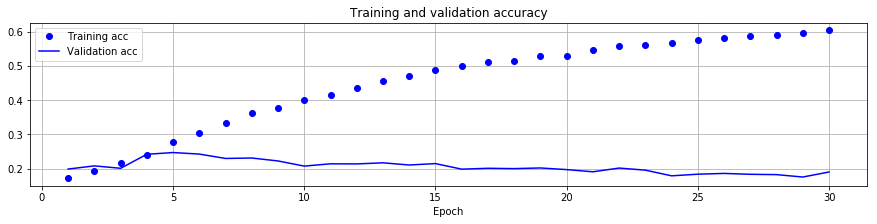

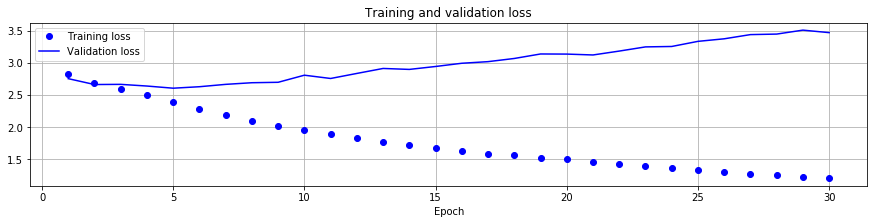

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

There is some heavy overfitting in the model despite the dropout arguments. Validation accuracy is extremely low and validation loss is extremely high. It is possible to see from the graph that overfitting starts after the fifth epoch. Interesting is that the testing accuracy and loss are better than validation results. 

### Metrics results

Sklearn library calculates the metrics. In here they are classification report that shows classification results per class, confusion matrix and possibility to check predictions by text.

In [13]:
# calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

In [14]:
# classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.47      0.48      0.47       423
          1       0.41      0.23      0.29       158
          2       0.62      0.32      0.42        65
          3       0.56      0.64      0.60      1163
          4       0.42      0.51      0.46       283
          5       0.55      0.52      0.54       588
          6       0.51      0.36      0.42       100
          7       0.45      0.49      0.47       473
          8       0.44      0.34      0.38       125
          9       0.53      0.51      0.52       621
         10       0.49      0.52      0.50       162
         11       0.55      0.53      0.54       491
         12       0.51      0.53      0.52       281
         13       0.63      0.69      0.66      1249
         14       0.51      0.32      0.39       215
         15       0.40      0.36      0.38       200
         16       0.60      0.40      0.48       295
         17       0.58      0.54      0.56   

In [15]:
# confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 100))

[[203   3   0   5  11  19   3  25   0  15   4   7   7  13   2   5   1   5   1  18  12   1  63]
 [ 16  36   0  12   1   6   0   7   1   2   2   2   6   2   0   0   2   0   0  48   0   1  14]
 [  8   0  21   3   1   3   0   2   0   3   5   1   6   2   0   0   0   1   0   2   1   1   5]
 [  2   1   1 745  12  34  10  46  11  16   7  45  20  13   5   4   9  11  10  33  12   0 116]
 [  5   1   0   5 144   3   2   3   2  19   2   2   1   3   3   6   7   6   4   3  15   0  47]
 [ 18   4   2  47   7 308   1   7   0   9   2  12   4   8   2   2   0   9   0   7  20   1 118]
 [  4   1   0  19   3   0  36   4   1   0   0   1   0   3   2   3   3   1   2   3   0   0  14]
 [ 25   3   0  40   4   9   2 231   4   6   1   5   4  20   3   4   1   3   0  13  10   3  82]
 [  4   0   0  19   9   1   1  13  42   1   1   0   0   1   1   2   3   1   0   1   1   0  24]
 [  9   1   1  33  12   6   0   6   2 318   9   6   8  29   3   5   1   6   1  13  20   3 129]
 [  3   2   3   8   8   1   0   1   0   6  84   0 

This confusion matrix is not so great. The diagonal line from the upper left corner downwards should be formed from as big number as possible and everything else should be close to zero. And as you can see, in this model that is not happening. 

In [16]:
print(texts[indices[512]])

Pleuropulmonary manifestations of hepatic amebiasis 
 Pleuropulmonary manifestations of hepatic amebiasis occurred in 30 patients; 18 (60%) presented with at least 1 pulmonary complaint and 10 (33%) had multiple pulmonary symptoms.
 In 14 patients (47%), abnormalities were found on examination of the chest.
 In 16 chest roentgenograms (53%), there was at least 1 abnormality: right-sided pleural effusion (9 patients) and elevated right hemidiaphragm (8 patients) were the most common.
 All patients were treated with metronidazole (Flagyl) and had resolution of the amebic liver abscess and pulmonary disease.
 Pleuropulmonary disease is a common complication of amebic liver abscess.
 The clinical presentation and chest roentgenograms are virtually diagnostic and obviate the need for invasive procedures to confirm the diagnosis.
 Pleuropulmonary disease resolves with amebicidal treatment of the hepatic abscess.



True class:  2
Predicted class: 0
Predictions per class:
[ 0.27  0.02  0.01  0.    0.01  0.23  0.02  0.08  0.03  0.02  0.    0.
  0.01  0.    0.    0.    0.    0.    0.    0.04  0.04  0.02  0.17]


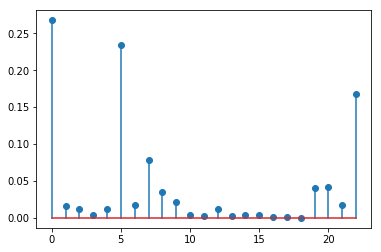

In [17]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

## 8. Conclusions

The Case 3. was a nice introduction to recurrent neural networks. I think the difficulty level was okay although it was more time consuming than I originally thought. Also I somehow completely forgot to do it and that's why I'm returning it late. The objectives were achieved such as the neural network works and is able to produce some kind of prediction. Alltogether I think this might have been the most interesting out of all three cases. 

The validation accuracy and loss were lower than test accuracy and loss and I could not seem to get myself to figure out why. With quick googling I only found reasons for validation accuracy being higher than training accuracy. Training accuracy is best at 0.6. Slightly over 0.28 test accuracy is also not good enough for a medical classifier. There is still some iossues to figure out with this model.